In [5]:
import os
os.chdir('/data/hyeryung/mucoco')
import yaml

import wandb
from tqdm import tqdm
import torch
import torch.nn as nn
import pandas as pd
from torch.optim import AdamW
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup, AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_fscore_support, accuracy_score


from new_module.em_training.nli.models import EncoderModel
from new_module.em_training.nli.data_handling import load_nli_data, load_nli_test_data, NLI_Dataset, NLI_DataLoader
from new_module.em_training.nli.train import *
from new_module.em_training.nli.train_modules import *


In [95]:
model_path = "models/nli/roberta_large_snli_mnli_anli_train_dev_with_finegrained_label_binary_cross_entropy/1726056021/best_model.pth"

In [96]:
config = load_config('new_module/em_training/config.yaml')
config['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = EncoderModel(config)
model = model.to(config['device'])
model.load_state_dict(torch.load(model_path))

config['model_path'] = model_path

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
## hf model
config = load_config('new_module/em_training/config.yaml')
model = AutoModelForSequenceClassification.from_pretrained('ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli')
model = model.to('cuda')
tokenizer = AutoTokenizer.from_pretrained('ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli')

Some weights of the model checkpoint at ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [97]:
train_dev_data = load_nli_data(output_file_path=config['energynet']['dataset_path'])
test_data = load_nli_test_data(output_file_path='/data/hyeryung/mucoco/data/nli/snli_mnli_anli_test_with_finegrained.jsonl')

train_data = train_dev_data.loc[train_dev_data['split'] == 'train']
dev_data = train_dev_data.loc[train_dev_data['split'] == 'dev']

## IMPT. 'finegrained_labels' == degree of contradiction (real number between 0 and 1) == portion of annotators who labeled the sample as "contradiction"
train_dataset = NLI_Dataset(train_data, label_column=config['energynet']['label_column'])
dev_dataset = NLI_Dataset(dev_data, label_column=config['energynet']['label_column'])
test_dataset = NLI_Dataset(test_data, label_column=config['energynet']['label_column'])

train_dataloader = NLI_DataLoader(dataset=train_dataset, 
                                    config = config, 
                                    mode='train', 
                                    tokenizer=model.tokenizer).get_dataloader()
dev_dataloader = NLI_DataLoader(dataset=dev_dataset, 
                                    config = config, 
                                    mode='dev', 
                                    tokenizer=model.tokenizer).get_dataloader()
test_dataloader = NLI_DataLoader(dataset=test_dataset,
                                 config=config,
                                 mode='test',
                                 tokenizer=model.tokenizer).get_dataloader()

Preprocessed dataset already exists. Loading data from file
Preprocessed dataset already exists. Loading data from file


In [12]:
## for hf model
test_data = load_nli_test_data(output_file_path='/data/hyeryung/mucoco/data/nli/snli_mnli_anli_test_with_finegrained.jsonl')
test_dataset = NLI_Dataset(test_data, label_column=config['energynet']['label_column'])

from torch.utils.data import Dataset, DataLoader
class NLI_DataLoader:
    
    def __init__(self, dataset, config, mode, tokenizer):
        self.tokenizer = tokenizer
        self.dataset = dataset
        self.config = config
        self.batch_size = self.config['energynet']['batch_size']
        self.mode = mode
    
    def collate_fn(self, batch):
        premises = [x[0] for x in batch]
        hypotheses = [x[1] for x in batch]
        labels = [x[2] for x in batch]
        finegrained_labels = [x[3] for x in batch]
        
        sequences = [(p, h) for p, h in zip(premises, hypotheses)]
        tokenized_sequences = self.tokenizer(sequences, padding=True, truncation=True, return_tensors='pt')
        if self.config['energynet']['loss'] == 'cross_entropy':
            labels = torch.Tensor(labels).reshape(-1, 1)
            labels = torch.tile(labels, (1,2))
            labels[:, 0] = 1 - labels[:, 0] 
        elif self.config['energynet']['loss'] == 'binary_cross_entropy':
            labels = torch.LongTensor(labels)
        elif self.config['energynet']['loss'] == 'mse':
            labels = torch.Tensor(labels).reshape(-1, 1)
        else:
            raise NotImplementedError('Label column not recognized')
        
        return {'input_ids': tokenized_sequences['input_ids'].to(self.config['device']), 
                'attention_mask': tokenized_sequences['attention_mask'].to(self.config['device']), 
                'labels': labels.to(self.config['device']),
                'finegrained_labels': finegrained_labels}
    
    def get_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True if self.mode=='train' else False, collate_fn=self.collate_fn)
    
test_dataloader = NLI_DataLoader(dataset=test_dataset,
                                 config=config,
                                 mode='test',
                                 tokenizer=tokenizer).get_dataloader()
        

Preprocessed dataset already exists. Loading data from file


In [98]:
print(f"num batches in train data: {len(train_dataloader)}")
print(f"num batches in dev data: {len(dev_dataloader)}")
print(f"num batches in test data: {len(test_dataloader)}")

num batches in train data: 3156
num batches in dev data: 351
num batches in test data: 814


In [10]:
if (config['energynet']['loss'] == 'cross_entropy') or (config['energynet']['loss'] == 'binary_cross_entropy'):
    criterion = nn.CrossEntropyLoss()
elif config['energynet']['loss'] == 'mse':
    criterion = nn.MSELoss()
else:
    raise NotImplementedError('Not a valid loss name')

In [100]:
config

{'energynet': {'base_model': 'roberta-large',
  'output_form': '2dim_vec',
  'energy_col': 1,
  'label_column': 'label',
  'batch_size': 16,
  'num_epochs': 3,
  'max_lr': '1e-5',
  'weight_decay': 0.03,
  'loss': 'binary_cross_entropy',
  'eval_every': 100,
  'ckpt_save_path': 'models/nli',
  'dataset_path': 'data/nli/snli_mnli_anli_train_dev_with_finegrained.jsonl'},
 'locate': {'type': 'gradnorm'},
 'device': device(type='cuda'),
 'model_path': 'models/nli/roberta_large_snli_mnli_anli_train_dev_with_finegrained_label_binary_cross_entropy/1726056021/best_model.pth'}

In [101]:
epoch=0
overall_step=0
model.eval()
with torch.no_grad():
    dev_loss = 0
    dev_e = []
    dev_labels = []
    for dev_batch in test_dataloader:
        
        if config['locate']['type'] == 'gradnorm':
            dev_outputs, _ = model(input_ids = dev_batch['input_ids'],
                        attention_mask = dev_batch['attention_mask'])
        else:
            dev_outputs = model(input_ids = dev_batch['input_ids'],
                        attention_mask = dev_batch['attention_mask'])
        if config['energynet']['loss'] == 'mse': 
            dev_predictions = torch.sigmoid(dev_outputs)
        else:
            dev_predictions = dev_outputs
        
        dev_loss += criterion(dev_predictions, dev_batch['labels'])
        
        if (config['energynet']['loss'] == 'cross_entropy') or (config['energynet']['loss'] == 'binary_cross_entropy'):
            dev_predictions = torch.softmax(dev_outputs, dim=-1)
            
        dev_e.extend(dev_predictions.cpu().squeeze(-1).tolist())
        try:
            dev_labels.extend(dev_batch['labels'].cpu().squeeze(-1).tolist())
        except:
            dev_labels.extend(dev_batch['labels'].cpu().tolist())
        
    dev_loss /= len(dev_dataloader)
    


In [19]:
## hf model
config['locate']['type'] = 'attention'
epoch=0
overall_step=0
model.eval()
with torch.no_grad():
    dev_loss = 0
    dev_e = []
    dev_labels = []
    for dev_batch in test_dataloader:
        
        if config['locate']['type'] == 'gradnorm':
            dev_outputs, _ = model(input_ids = dev_batch['input_ids'],
                        attention_mask = dev_batch['attention_mask'])
        else:
            dev_outputs = model(input_ids = dev_batch['input_ids'],
                        attention_mask = dev_batch['attention_mask'])
        if config['energynet']['loss'] == 'mse': 
            dev_predictions = torch.sigmoid(dev_outputs)
        else:
            dev_predictions = dev_outputs
        
        # dev_loss += criterion(dev_predictions, dev_batch['labels'])
        
        if (config['energynet']['loss'] == 'cross_entropy') or (config['energynet']['loss'] == 'binary_cross_entropy'):
            dev_outputs = dev_outputs.logits
            dev_predictions = torch.softmax(dev_outputs, dim=-1)
            
        dev_e.extend(dev_predictions.cpu().squeeze(-1).tolist())
        try:
            dev_labels.extend(dev_batch['labels'].cpu().squeeze(-1).tolist())
        except:
            dev_labels.extend(dev_batch['labels'].cpu().tolist())
        
    # dev_loss /= len(dev_dataloader)
    


In [21]:
try:
    contradict_proba = torch.Tensor(dev_e)[:, 1]
except:
    contradict_proba = torch.Tensor(dev_e)

try:
    contradict_labels = torch.Tensor(dev_labels)[:, 1]
except: 
    contradict_labels = torch.Tensor(dev_labels)
    
print(f"contradict_proba: {contradict_proba[:10]}")
print(f"contradict_labels: {contradict_labels[:10]}")

contradict_proba: tensor([6.0456e-02, 4.9832e-03, 9.9525e-01, 3.4193e-03, 3.0764e-03, 5.5597e-01,
        9.3100e-04, 1.2835e-03, 8.7605e-01, 3.4315e-02])
contradict_labels: tensor([0., 0., 1., 0., 0., 1., 0., 0., 1., 0.])


In [22]:
## hf
try:
    contradict_proba = torch.Tensor(dev_e)[:, 2]
except:
    contradict_proba = torch.Tensor(dev_e)

try:
    contradict_labels = torch.Tensor(dev_labels)[:, 1]
except: 
    contradict_labels = torch.Tensor(dev_labels)
    
print(f"contradict_proba: {contradict_proba[:10]}")
print(f"contradict_labels: {contradict_labels[:10]}")

contradict_proba: tensor([6.0456e-02, 4.9832e-03, 9.9525e-01, 3.4193e-03, 3.0764e-03, 5.5597e-01,
        9.3100e-04, 1.2835e-03, 8.7605e-01, 3.4315e-02])
contradict_labels: tensor([0., 0., 1., 0., 0., 1., 0., 0., 1., 0.])


Precision: 0.88
Recall: 0.81
F1 Score: 0.84


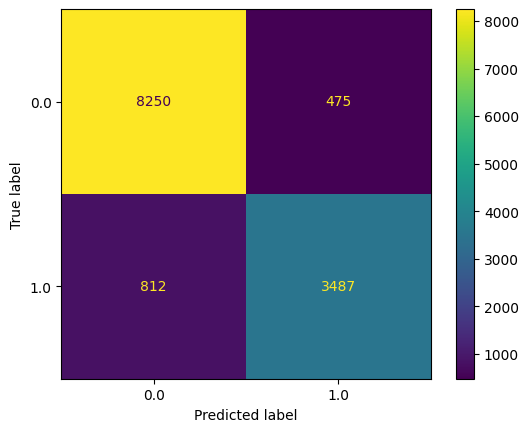

In [23]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support 
from sklearn.metrics import ConfusionMatrixDisplay


th = 0.5
contradict_proba_c = torch.where(contradict_proba > th, 1, 0)
try:
    ConfusionMatrixDisplay.from_predictions(contradict_labels, contradict_proba_c)
    precision, recall, fbeta_score, support = precision_recall_fscore_support(contradict_labels, contradict_proba_c, average='binary')
except:
    contradict_labels_c = torch.where(contradict_labels > th, 1, 0)
    ConfusionMatrixDisplay.from_predictions(contradict_labels_c, contradict_proba_c)
    precision, recall, fbeta_score, support = precision_recall_fscore_support(contradict_labels_c, contradict_proba_c, average='binary')


print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {fbeta_score:.2f}")

In [26]:
contradict_labels = test_data['finegrained_labels'].values

print(torch.mean((contradict_proba-contradict_labels)**2))

from scipy.stats import pearsonr 
print(pearsonr(contradict_proba, contradict_labels))

tensor(0.0748, dtype=torch.float64)
PearsonRResult(statistic=0.800729486479123, pvalue=0.0)


In [27]:
# arr_inconsistent = [p for i, p in enumerate(contradict_proba) if contradict_labels[i] == 1]
# arr_consistent = [p for i, p in enumerate(contradict_proba) if contradict_labels[i] == 0]
arr_inconsistent = [p for i, p in enumerate(contradict_proba) if contradict_labels[i] > 0.5]
arr_consistent = [p for i, p in enumerate(contradict_proba) if contradict_labels[i] <= 0.5]

In [106]:
determine_best_split_by_f1(arr_consistent, arr_inconsistent)

/data/hyeryung/.conda/envs/loc-edit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'best_f1_threshold': 0.5000894679687914,
 'best_f1_f1': 0.0,
 'best_f1_precision': 0.0,
 'best_f1_recall': 0.0,
 'best_f1_accuracy': 0.3300829238329238}

In [28]:

def plot_roc_curve_real_num(array_positive, array_negative, path_to_save_figure):
    """
    code adapted from Mooho's code
    """
    # Combine the positive and negative arrays
    y_true = np.array([1] * len(array_positive) + [0] * len(array_negative))
    pos = [-1 * a for a in array_positive]
    neg = [-1 * a for a in array_negative]
    # scores = np.array(array_positive + array_negative) 
    scores = np.array(pos + neg) 
    
    # Calculate FPR and TPR for various thresholds
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    auroc = roc_auc_score(y_true, scores)
    
    # Plotting the ROC curve
    fig = plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve with AUROC={auroc:.4f}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    
    # Save the plot to the specified path
    # plt.savefig(path_to_save_figure)
    # plt.close()
    return auroc

0.9145764024551589

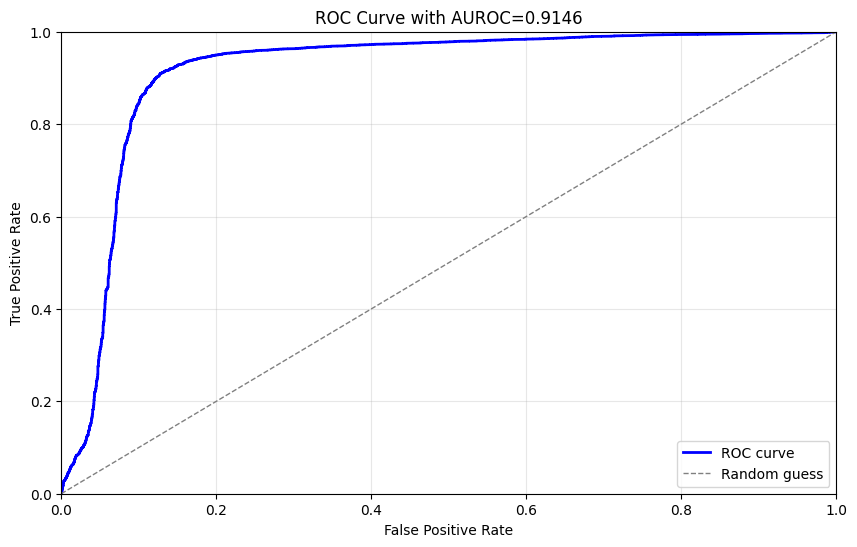

In [29]:
plot_roc_curve_real_num(arr_consistent, arr_inconsistent, "")

Text(0.5, 1.0, 'hist')

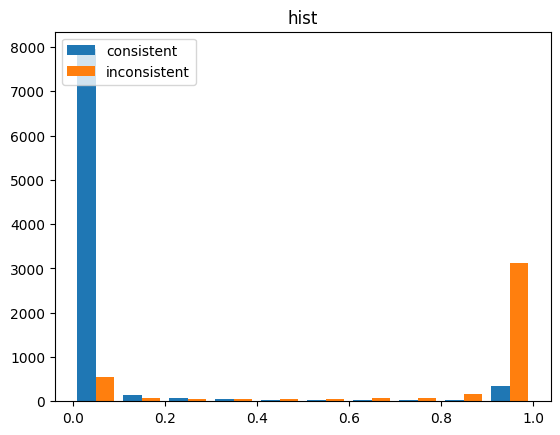

In [30]:
plt.hist([arr_consistent, arr_inconsistent], label = [ "consistent", "inconsistent"])
plt.legend(loc="upper left")
plt.title("hist")

In [31]:
def plot_observed_predicted_boxplot(array_energy, array_labels, path_to_save_figure):
    predicted_result = pd.DataFrame({'labels': array_labels, 'predicted_proba': array_energy})
    predicted_result['labels_c'] = pd.cut(predicted_result['labels'], np.arange(-0.1, 1.01, 0.1))
    g = sns.boxplot(predicted_result, x='labels_c', y='predicted_proba')
    plt.xticks(rotation=30)
    plt.xticks(rotation=30)
    plt.title("Predicted Values by Bins of Observed Values")
    plt.xlabel("Bins in Labels")
    plt.ylabel("Energy")
    # plt.savefig(path_to_save_figure)
    # plt.close()

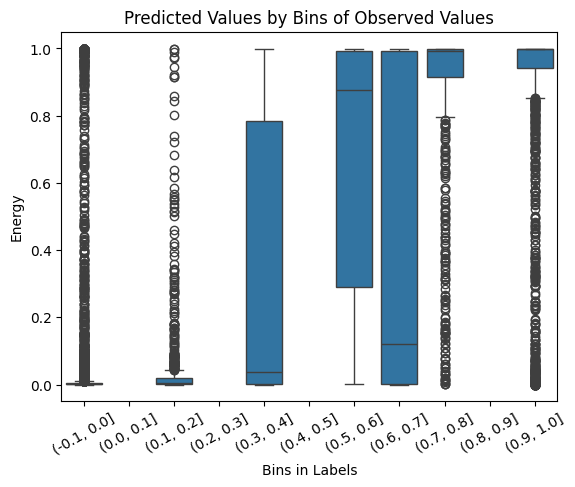

In [32]:
# plot_observed_predicted_boxplot(contradict_proba, dev_data['finegrained_labels'].values, '')
plot_observed_predicted_boxplot(contradict_proba, test_data['finegrained_labels'].values, '')